In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import sympy
from plot import *

# from sympy import *
# from sympy.physics.units import *

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

def display_var(var, value, unit=None, preface=None):
    display(Markdown("$\\text{{ {}${} = {:.3f} \\text{{ {} }} $ }} $".format(preface or "", var, value, unit or "")))


# Veloceration

_Introduction_

# Background


# Aproach
## Simulation

Simulating a system like this is actually rather straight forward. The goal of each simulation is to determine the performance of each set of parameters. The key parameters are the sample frequency, $f_s$, which affects the limits of all other parameters and performance characteristics. Primarily, it determines the highest frequency which can be detected by the system, in accordance with the Nyquist Sampling Theorm $f_s > 2f_{max}$. In our application, $f_{max}$ is going to be the emitted frequency doppler shifted by the maximum speed we want to detect. In general, the doppler shift will be very small compared to the frequency itself, so we'll generalize the constraint to be

$$ f_s > 2f_0 $$

where f_0 is the emitted frequency. $f_0$ itself affects the performance characteristics a marginal amount. The doppler effect is defined as

$$ f_\text{doppler} = {c \over c+v} f_0 $$

When a standard Discrete Fourier Transform is used to find frequencies, a higher $f_0$ will result in a proportional shift in $f_\text{doppler}$ as a result, which will span more frequency bins in the transform.

In [2]:
c = 343 # m/s

# Returns the frequency shifted by the doppler effect for a given velocity 'v'
def doppler(f0, v):
    return c / (c + v) * f0

display_var(
    "f_0 - f_\\text{doppler}"
    , 5000 - doppler(5000, 1)
    , "Hz"
    , " for $f_0 = 5000$ Hz: "
)

display_var(
    "f_0 - f_\\text{doppler}"
    , 22000 - doppler(22000, 1)
    , "Hz"
    , " for $f_0 = 22000$ Hz: "
)

$\text{  for $f_0 = 5000$ Hz: $f_0 - f_\text{doppler} = 14.535 \text{ Hz } $ } $

$\text{  for $f_0 = 22000$ Hz: $f_0 - f_\text{doppler} = 63.953 \text{ Hz } $ } $

The next important parameter is $n_s$, which is the number of samples used for each Fourier Transform. First and foremost, $n_s$ determines the amount of time over which samples are gathered for one calculation, $T_{FFT}$. 

$$ T_{FFT} = T_s n_s = {n_s \over f_s} $$

In [3]:
# Returns the sample period given a sample frequency
def sample_period(f_s):
    return 1 / f_s

# Returns the time (in seconds) over which one transform would be calculated
def fft_period(T_s, n):
    return T_s * n

display_var(
    "T_s"
    , sample_period(44100) * 1000
    , "ms"
)

display_var(
    "T_{FFT}"
    , fft_period(sample_period(44100), 8192) * 1000
    , "ms"
)

$\text{ $T_s = 0.023 \text{ ms } $ } $

$\text{ $T_{FFT} = 185.760 \text{ ms } $ } $

The number of samples also defines the number of frequency bins that will be in the resulting Transform $2n_\text{bins} = n_s$. The more frequency bins there are, the higher the resolution of the spectrum, $f_\text{bin}$ since those bins are distributed over the Nyquist frequency $f_s \over 2$.

In [4]:
# Returns the number of hertz per frequency bin in the fft
def freq_per_bin(T_s, n):
    return 1 / fft_period(T_s, n)

''' For a given set of parameters, returns the resolution with which
    the system will be able to detect the doppler effect.
    Essentially by resolution we mean the number of bins that span
    the range of velocities we want to detect.
'''
def resolution(T_s, n, f0, vmax):
    return abs(int((doppler(f0, vmax) - f0) / freq_per_bin(T_s, n)))

display_var(
    "f_\\text{bin}"
    , freq_per_bin(sample_period(44100), 8192)
    , "Hz"
)

display_var(
    "\\text{resolution}"
    , resolution(sample_period(44100), 8192, 22000, 1)
)

$\text{ $f_\text{bin} = 5.383 \text{ Hz } $ } $

$\text{ $\text{resolution} = 11.000 \text{  } $ } $

In general, $n_{s}$ will also be chosen as a power of 2 as FFT algorithms run most efficently for those sample counts.

With all of these parameters defined, we can simulate the signal that would be seen by a sensor rather simply.

The `signal_gen` function shown below generates the samples needed for the FFT. It takes in the sample-period $(T_s)$, the number of samples ($n$), and the emitted velocity ($f_0$).

Additionally, we need to simulate the actual kinematics of the sensor and object. This function takes in the position of the sensor ($p_\text{sensor}$), the starting point of the object ($p_\text{start}$), and the velocity of the object ($v$) in the same reference frame.

At each time-step, the function determines the position of the object relative to the sensor ($r$), and then finds the projection of the object's velocity along that vector ($w$). This is the speed needed to compute the frequency which will be sensed according to the doppler effect ($f$). Finally, each sample of the signal is modeled as the interference of two sinusoidal signals with the emitted frequency and shifted frequency.

The emitted frequency is added here to simulate the sensor's mic picking up $f_0$, which happens in the scheme where the sensor emits $f_0$ and the doppler shift occurs as it is reflected by the object's frequency. This term can be removed when simulating an object which is responsible for emitting $f_0$.

The `intensity_factor` being multiplied by the doppler frequency's sinusoidal is used to represent the attenuation of the pressure of a sound-wave picked up by a microphone. This pressure is taken inversely with distance. Its mutliplied by a constant here just to make it easy to see on the same scale as the $f_0$ spike.

NameError: name 'v_rads' is not defined

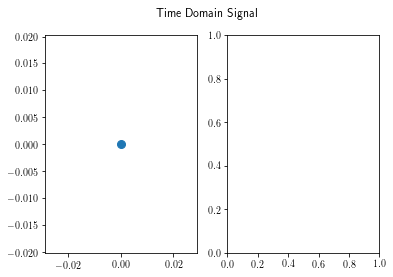

In [5]:
''' Generates the signal received by a sensor at 'sensor' and a target object
    at 'start' moving at a 'velocity' due to the doppler effect of the
    frequency 'f0'
'''
def signal_gen(T_s, n, p_sensor, p_start, v, f0):
    t = 0
    for i in range(n):
        r = p_sensor - p_start + v*t
        
        # Used to scale the shifted frequency inversely with distance
        intensity_factor = 1/la.norm(r)*1.1
        
        w = np.dot(v, r / la.norm(r))
        f = doppler(f0, w)
        yield intensity_factor*math.sin(2*math.pi*f*t) + math.sin(2*math.pi*f0*t)
        t += T_s
        
f0 = 21000
f_s = 44100
T_s = sample_period(f_s)
n = 4096
p0 = np.array([0, 0])
p = np.array([1, 1])
v = np.array([1, 1])

signal = list(
    signal_gen(
        T_s
        , 4096
        , p0
        , p
        , v
        , f0
    )
)

times = [i*T_s for i in range(len(signal))]

setup, far = side_by_side("Time Domain Signal")

plot_layout(setup, [p0], p=p, v=v)

simple_plot(
    far
    , signal
    , times
    , xlabel="Time (s)"
)


The left plot shows the first 100 samples of the generated signal. Since $f_0$ is so close to the Nyquist frequency, almost every sample is inverted from the last. Here, the sinusoidal amplitude change is a result of the sample frequency offsetting from $f_0$. In the right plot the full sample is shown. Here, the sinusoidal amplitude change is a result of the emitted frequency $f_0$ offsetting from $f$ interfering in and out of phase.

This is the extent of the simulation, the rest of the code treats these incoming signals the same way a physical microphone would, such that the code _could_ be deployed to a physical system.

## Algorithm

### Individual Sensor Frequency Extraction
To determine the dominant frequencies in the incoming signals, a numpy method which computes a Discrete Fourier Transform is used. `np.fft.rfft` is the real fft, which operates on real valued samples. Since real-valued frequency transforms just have duplicate bins for complex conjugates, this function only returns half of the frequency spectrum, so the number of bins is half of the number of samples.

In [ ]:
def freq_spectrum(signal):
    return [np.absolute(sample) for sample in np.fft.rfft(signal)]

# reusing signal calculated above
spectrum = freq_spectrum(signal)
n_bins = len(spectrum)
display_var("n_\\text{bins}", n_bins)
plot(spectrum)

Here the frequency spectrum of the signal from earlier is shown. As expected, there are two spikes in the spectrum. One around $f_0$, and one offset from $f_0$ which is spread over a slightly larger region and is less uniform.

The next few functions are used to help find the peak in the spectrum representing the shifted frequency. 

In [ ]:
# Finds a local min
def find_next_low(data):
    minv = None
    for i, v in enumerate(data):
        if minv is None:
            minv = v
        elif v < minv:
            minv = v
        else:
            return i-1
    return len(data)

# Finds the global max starting at the first local min
def find_next_peak(data):
    maxv = 0
    ret = 0
    start = find_next_low(data)
    data = data[start:]
    for i, v in enumerate(data):
        if v > maxv:
            maxv = v
            ret = i   
    return start + ret

# Returns mean and standard deviation of input data
def characterize_peak(data):
    sumweight = 0
    sumdata = 0
    for i, v in enumerate(data):
        sumweight += v
        sumdata += i*v

    mean = sumdata / sumweight

    variance = 0
    for i, v in enumerate(data):
        variance += v / sumweight * (mean - i)**2

    std_dev = math.sqrt(variance)

    return (mean, std_dev)

These are utilized in the `find_shift` function, which works by searching from the $f_0$ frequency in both directions, looking for the highest peak in the data, excluding the $f_0$ peak.

It then returns the offset $\Delta f$ of that frequency, the standard deviation of the confidence interval of the frequency $\sigma_f$, and the intensity of the peak $a$ relative to the intensity of $f_0$ (measured in Pascals).

In [ ]:
# Used to determine how far from f0 find_shift will search for a doppler shifted frequency
max_vel = 30

''' Finds the doppler shifted frequency in a spectrum about f0.
    Returns the mean and standard deviation.
    
    This function takes the input spectrum and searches for the shifted frequency
    by scanning left and right from the bin corresponding to f0 for the highest
    spike in the data. 
'''
def find_shift(T_s, f0, spectrum):
    n = (len(spectrum)-1)*2
    fpb = freq_per_bin(T_s, n)
    
    peak_range = doppler(f0, max_vel)
    
    f0_bin = round(f0 / fpb)
    bin_range = int(peak_range / fpb)
    
    
    # Find highest bin in search range to left and right of f0 peak
    left_peak = f0_bin - find_next_peak(spectrum[f0_bin:f0_bin-bin_range:-1])
    right_peak = f0_bin + find_next_peak(spectrum[f0_bin:f0_bin+bin_range])
    
    max_peak = max((left_peak, right_peak),
                key=lambda x: spectrum[x] if 0 <= x < len(spectrum) else 0)
    
    peak_start = find_next_low(spectrum[max_peak:max_peak-bin_range:-1])
    peak_end = find_next_low(spectrum[max_peak:max_peak+bin_range])
    
    # symmetry
    peak_start = peak_end = min(peak_start, peak_end)
    
    if peak_start == 0:
        return 0, 2*freq_per_bin(sample_period, samples), 0
    
    mean, std_dev = characterize_peak(spectrum[max_peak-peak_start:max_peak+peak_end])
    mean += max_peak-peak_start
    
    freq_mean = mean*fpb
    std_dev = std_dev*fpb
    
    return f0 - freq_mean, std_dev, spectrum[max_peak]/spectrum[f0_bin]

df, sigma, a = find_shift(T_s, f0, spectrum)
display_var(
    "f_\\text{shift} = \Delta f"
    , df
    , "Hz"
    , "Frequency Shift: "
)

display_var(
    "\sigma_f"
    , sigma
    , "Hz"
    , "Standard Deviation: "
)

display_var(
    "a"
    , a
    , "Pa"
    , "Sound Pressure Intensity: "
)

With the frequency shift we can extract the velocity that generated it, by using the doppler effect equation. This can also be applied to our standard deviation value to get the standard deviation of this velocity value.

In [ ]:
c = 343 # m/s

# Returns the velocity based on the known frequency shift
def inv_doppler(f0, df):
    return df/f0*c

v_doppler = inv_doppler(f0, df)
sigma_doppler = inv_doppler(f0, sigma)
display_var(
    "v_\\text{doppler}"
    , dopple_v
    , "m/s"
    , "Doppler Velocity: "
)
display_var(
    "\sigma_{v_\\text{doppler}}"
    , sigma_doppler
    , "m/s"
    , "Doppler Velocity: "
)

Recalling from the beginning of this example simulation, the original velocity was $[1, 1]^T$, which has magnitude $\sqrt{2} \approx 1.41$, which is close to our calculated velocity, and certainly within the $1\sigma_{v_\text{doppler}}$ confidence interval.

#### Performance



### Estimation

With each sensor giving the velocity of the object along its radial axis, we want to derive the velocity of the object in the world space.

Given an object at unknown position $\vec q$ moving at unknown velocity $\vec v = \dot q$ and given the positions of $m$ sensors $\{\vec p_0 \ldots \vec p_{m-1}\}$, and the radial velocities of the object towards each sensor $\{\dot r_0, \ldots \dot r_{m-1} \}$, we want to find the velocity $\vec v$ of the object.

For starters, we have the distance equation of each sensor $i$ to the object:

$$ \lVert q - p_i \rVert^2  = r_i^2 $$

Then, we take the derivative of this equation with respect to time.

$$
\begin{align*}
    \lVert \vec q - \vec p_i \rVert^2 &=  r_i^2 \\
    (\vec q - \vec p_i) \cdot (\vec q - \vec p_i) &= r_i^2 \\
    2 (\vec q - \vec p_i) \cdot \dot q &= 2 r_i \dot r_i \\
    (\vec q - \vec p_i) \cdot \dot q &= r_i \dot r_i \\
    \vec q \cdot \dot q - \vec p_i \cdot \dot q &= r_i \dot r_i \\
    \vec q \cdot \dot q &= r_i \dot r_i + \vec p_i \cdot \dot q \\
\end{align*}
$$

In this final form, the left side of the equation is independent of the sensors, and so given a pair of sensors $i$ and $j$, we can set the right sides of their equations equal to each other:

$$
\begin{align*}
    r_i \dot r_i + \vec p_i \cdot \dot q &= r_j \dot r_j + \vec p_j \cdot \dot q \\
    \vec p_i \cdot \dot q - \vec p_j \cdot \dot q + r_i \dot r_i - r_j \dot r_j &= 0 \\
    (\vec p_i - \vec p_j) \cdot \dot q + \dot r_i r_i - \dot r_j r_j &= 0 \\
\end{align*}
$$

